# **Table of Contents**

- [Introduction](#Introduction)
- [Importing Libraries](#Importing-Libraries)
- [Lasso Regression](#lasso-regression)
- [Ridge Regression](#Ridge-regression)
- [ElasticNet Regression](#elasticNet-regression)
- [Results](#Results)
- [Conclusion](#Conclusion)

## Introduction
### Regression Analysis: Day 4 - Regularization
- This notebook focuses on regularization techniques like Laaso, Ridge, ElasticNet to improve model.

## Importing Libraries

In [1]:
import sys
sys.path.append("../../")
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
from functions.eda import *
from functions.cat_eda import *
from functions.num_eda import *
from functions.pipeline_helpers import *

In [2]:
train_data=pl.read_csv("train_featureEngineered.csv")
test_data=pl.read_csv("test_featureEngineered.csv")
train_data.shape,test_data.shape

((140, 12), (62, 12))

In [3]:
cat_cols=[col for col in train_data.columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("car_ID","price").columns if train_data[col].dtype!= pl.String]

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso
from sklearn.preprocessing import OneHotEncoder,StandardScaler
imputer = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='infrequent_if_exist',drop='first',min_frequency=9), cat_cols),
    ('num', StandardScaler(), num_cols)
],remainder="passthrough")

## Lasso Regression

Mean absolute Error: 2220.4723342910133
R-squared on holdout set: 0.7955884391612
Adjusted R-squared on holdout set: 0.7555077409575137


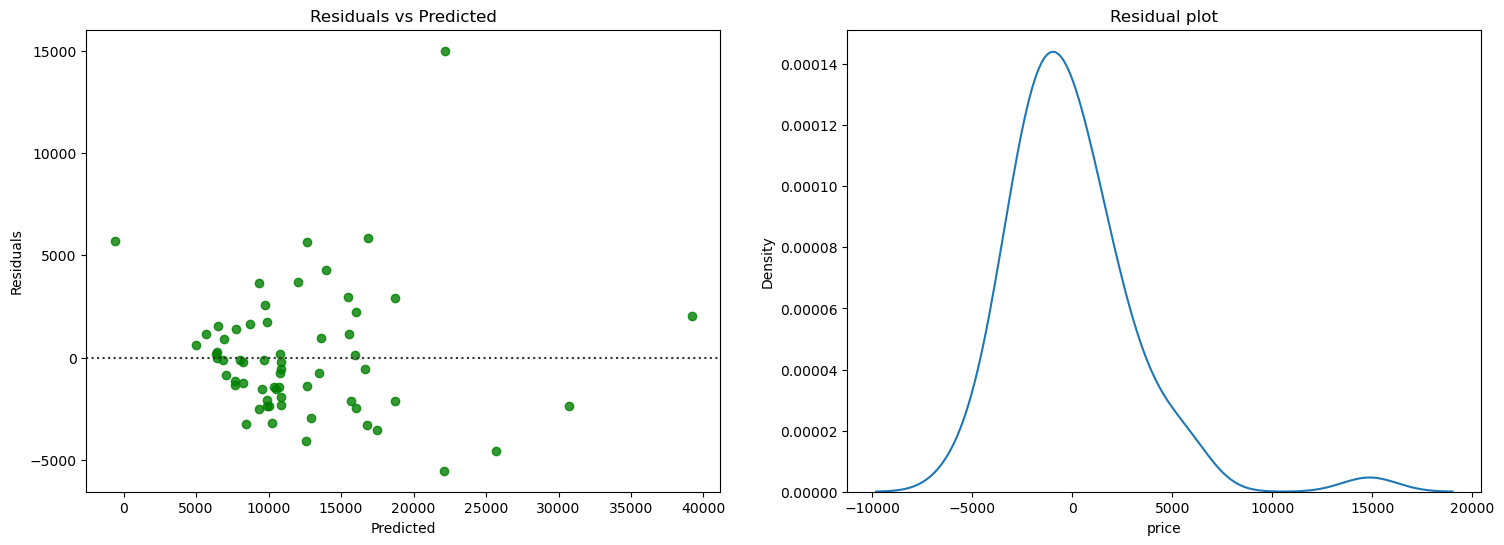

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict,cross_val_score,RepeatedKFold
from sklearn.metrics import mean_absolute_error,r2_score
from skopt import BayesSearchCV
import statsmodels.api as sm

lasso_pipe = Pipeline(steps=[
    ('imputer', imputer),
    ("regressor",Lasso())
])

X_train=train_data.drop('price',"car_ID").to_pandas()
y_train=train_data['price'].to_pandas()
X_test=test_data.drop('price',"car_ID").to_pandas()
y_test=test_data['price'].to_pandas()

rkf=RepeatedKFold(n_splits=10,random_state=42)
param_space = {
    'regressor__alpha': (1e-3, 1e3, 'log-uniform'),
}
lasso_bayes_search = BayesSearchCV(estimator=lasso_pipe, search_spaces=param_space, n_iter=20, cv=rkf, n_jobs=-1, random_state=42)
lasso_bayes_search.fit(X_train, y_train)

best_alpha = lasso_bayes_search.best_params_['regressor__alpha']

lasso_pipe.set_params(regressor__alpha=best_alpha)
lasso_pipe.fit(X_train, y_train)

cv_scores = cross_val_score(lasso_pipe, X_train, y_train, cv=rkf,n_jobs=-1)

sc=StandardScaler()
predictions = cross_val_predict(lasso_pipe, X_test, y_test,groups=X_test["aspiration"])
residuals = y_test - predictions
std_residuals = sc.fit_transform(residuals.values.reshape(-1, 1))
std_residuals = std_residuals.flatten()
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_true=y_test,y_pred= predictions)
n,p = X_test.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Mean absolute Error: {mae}')
print(f'R-squared on holdout set: {r2}')
print(f'Adjusted R-squared on holdout set: {adjusted_r2}')
# Plotting residuals
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(18, 6))
sns.residplot(x=predictions, y=residuals, color='g', ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(residuals, ax=ax2)
ax2.set_title("Residual plot")
plt.show()

## Ridge Regression

Mean absolute Error: 2220.4723342910133
R-squared on holdout set: 0.7955884391612
Adjusted R-squared on holdout set: 0.7555077409575137


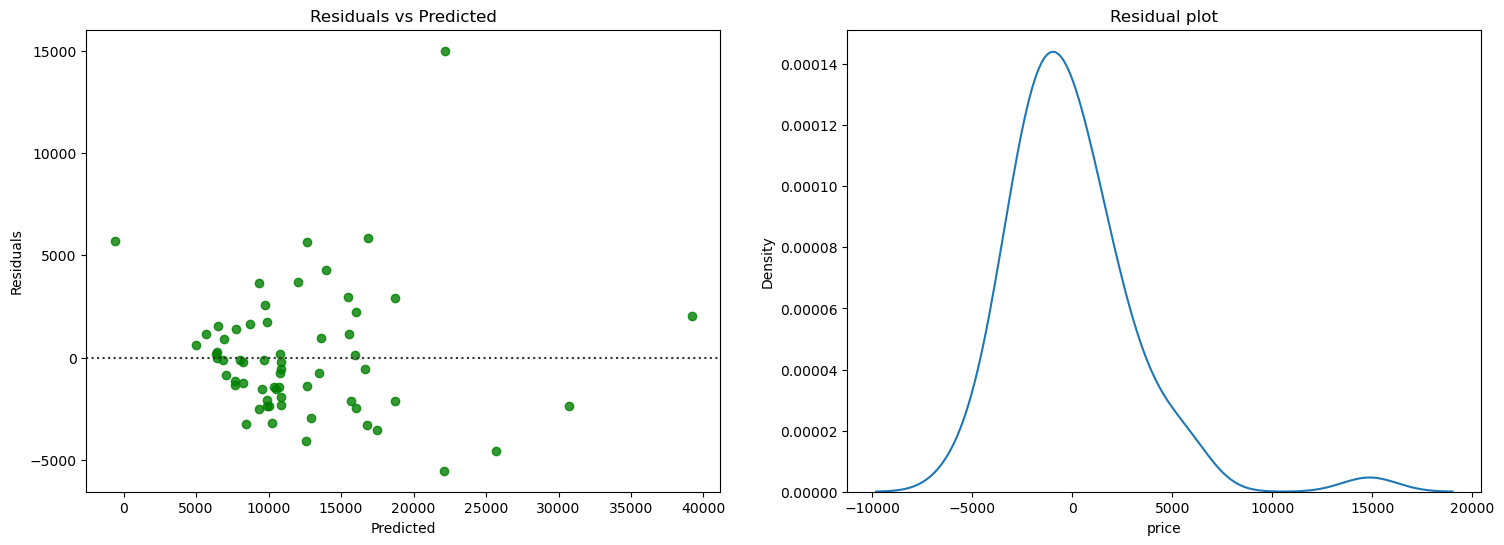

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict,cross_val_score,RepeatedKFold
from sklearn.metrics import mean_absolute_error,r2_score
from skopt import BayesSearchCV
import statsmodels.api as sm

ridge_pipe = Pipeline(steps=[
    ('imputer', imputer),
    ("regressor",Ridge())
])

rkf=RepeatedKFold(n_splits=10,random_state=42)
param_space = {
    'regressor__alpha': (1e-3, 1e3, 'log-uniform'),
}
ridge_bayes_search = BayesSearchCV(estimator=ridge_pipe, search_spaces=param_space, n_iter=20, cv=rkf, n_jobs=-1, random_state=42)
ridge_bayes_search.fit(X_train, y_train)

best_alpha = ridge_bayes_search.best_params_['regressor__alpha']

ridge_pipe.set_params(regressor__alpha=best_alpha)
ridge_pipe.fit(X_train, y_train)

cv_scores = cross_val_score(ridge_pipe, X_train, y_train, cv=rkf)

sc=StandardScaler()
predictions = cross_val_predict(lasso_pipe, X_test, y_test,groups=X_test["aspiration"])
residuals = y_test - predictions
std_residuals = sc.fit_transform(residuals.values.reshape(-1, 1))
std_residuals = std_residuals.flatten()
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_true=y_test,y_pred= predictions)
n,p = X_test.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Mean absolute Error: {mae}')
print(f'R-squared on holdout set: {r2}')
print(f'Adjusted R-squared on holdout set: {adjusted_r2}')
# Plotting residuals
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(18, 6))
sns.residplot(x=predictions, y=residuals, color='g', ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(residuals, ax=ax2)
ax2.set_title("Residual plot")
plt.show()

## ElasticNet Regression

Mean Train Score: 0.9124030060976641
Standard Deviation of Train Scores: 0.0059883578404992385
Mean Test Score: 0.8726280823745404
Standard Deviation of Test Scores: 0.08551511418113852
Mean absolute Error: 2098.5110383850156
R-squared on holdout set: 0.8100840449127641
Adjusted R-squared on holdout set: 0.7728456223466393


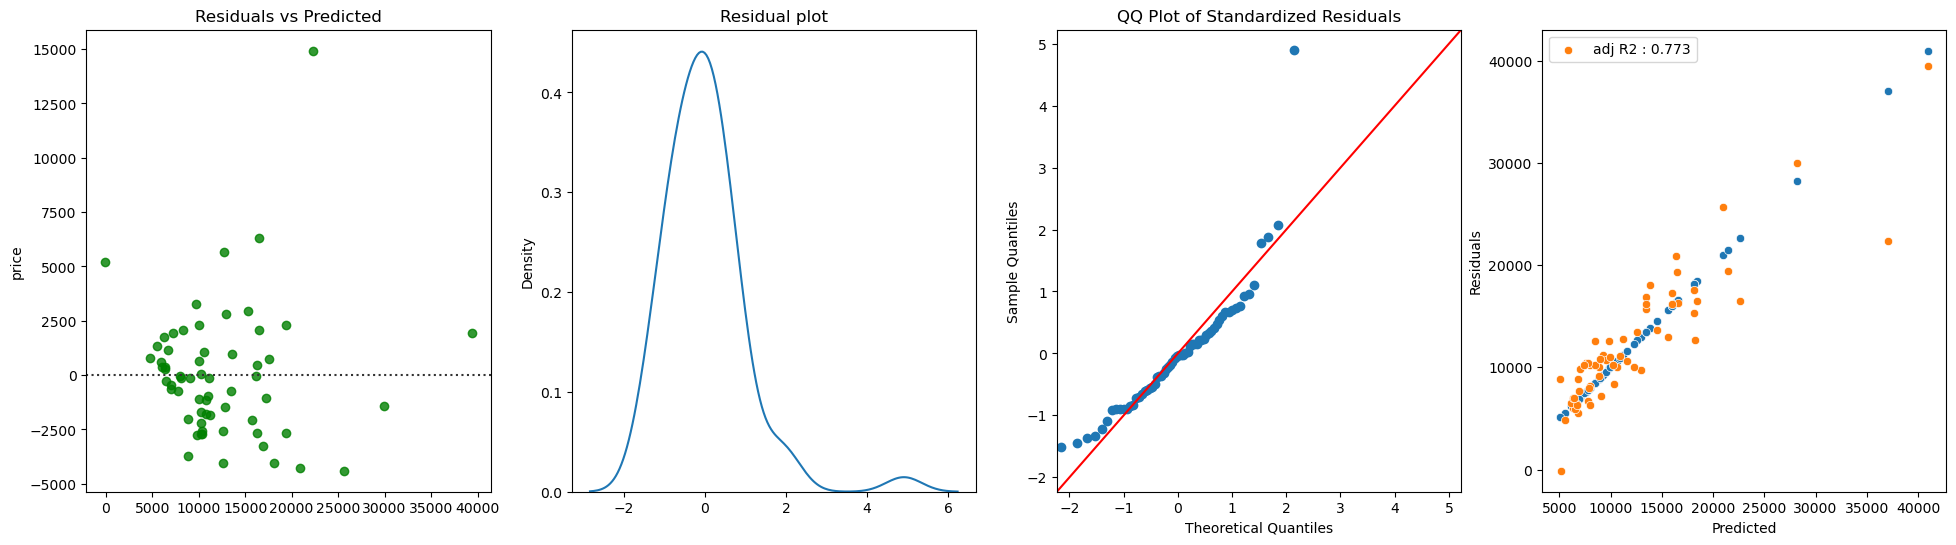

In [9]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_validate
from skopt import BayesSearchCV

elastic_pipe = Pipeline([
    ('imputer', imputer),
    ('regressor', ElasticNet())
])
param_space = {
    'regressor__alpha': (1e-3, 1e3, 'log-uniform'),
    'regressor__l1_ratio': (0.1, 0.9),
    'regressor__fit_intercept': (True,False),
}

rkf=RepeatedKFold(n_splits=10,random_state=42)
elasticnet_bayes_search = BayesSearchCV(estimator=elastic_pipe, search_spaces=param_space, n_iter=20, cv=rkf, n_jobs=-1, random_state=42)
elasticnet_bayes_search.fit(X_train, y_train)

best_alpha = elasticnet_bayes_search.best_params_['regressor__alpha']
best_l1_ratio = elasticnet_bayes_search.best_params_['regressor__l1_ratio']
best_fit_intercept = elasticnet_bayes_search.best_params_['regressor__fit_intercept']

elastic_pipe.set_params(regressor__alpha=best_alpha)
elastic_pipe.set_params(regressor__l1_ratio=best_l1_ratio)
elastic_pipe.set_params(regressor__fit_intercept=best_fit_intercept)
elastic_pipe.fit(X_train, y_train)

cv_results = cross_validate(elastic_pipe, X_train,y_train, cv=rkf, scoring='r2',n_jobs=-1,return_train_score=True)
print(f'Mean Train Score: {cv_results["train_score"].mean()}')
print(f'Standard Deviation of Train Scores: {cv_results["train_score"].std()}')
print(f'Mean Test Score: {cv_results["test_score"].mean()}')
print(f'Standard Deviation of Test Scores: {cv_results["test_score"].std()}')

sc=StandardScaler()
predictions = cross_val_predict(elastic_pipe, X_test, y_test,n_jobs=-1)
residuals = y_test - predictions
std_residuals = sc.fit_transform(residuals.values.reshape(-1, 1))
std_residuals = std_residuals.flatten()
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_true=y_test,y_pred= predictions)
n,p = X_test.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f'Mean absolute Error: {mae}')
print(f'R-squared on holdout set: {r2}')
print(f'Adjusted R-squared on holdout set: {adjusted_r2}')

fig,[ax1,ax2,ax3,ax4] = plt.subplots(ncols=4,figsize=(24,6))
sns.residplot(x=predictions, y=residuals, color='g',ax=ax1)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(std_residuals,ax=ax2)
ax2.set_title("Residual plot")
# QQ plot
sm.qqplot(std_residuals, line='45', ax=ax3)
ax3.set_title('QQ Plot of Standardized Residuals')
sns.scatterplot(x=y_test,y=y_test,ax=ax4)
sns.scatterplot(x=y_test,y=predictions,ax=ax4,label=f"adj R2 : {adjusted_r2.round(3)}")
plt.show()

Elastic net regressor work better

In [8]:
elasticnet_bayes_search.best_params_

OrderedDict([('regressor__alpha', 0.15660135499479771),
             ('regressor__fit_intercept', True),
             ('regressor__l1_ratio', 0.1)])

### Model Performance Summary (Day 4)

#### Cross-Validation Results
- **Mean Train Score**: 0.9124
- **Standard Deviation of Train Scores**: 0.0060
- **Mean Test Score**: 0.8726
- **Standard Deviation of Test Scores**: 0.0855

#### Holdout Set Performance
- **Mean Absolute Error (MAE)**: 2098.5110
- **R-squared (R²)**: 0.8101
- **Adjusted R-squared**: 0.7728

### Insights and Comparison with Previous Days

#### Improvements and Changes
- **Consistency**: The mean test score increased from 0.8620 on Day 3 to 0.8726 on Day 4, and the standard deviation of test scores decreased slightly from 0.0910 to 0.0855. This indicates that the model's performance on unseen data has improved and become more consistent.
- **Error Magnitude**: The MAE improved significantly, decreasing from 2435.9653 on Day 3 to 2098.5110 on Day 4. This suggests that the model's predictions are now closer to the actual values, reducing the average prediction error by approximately 337 units.
- **Holdout Set R²**: The R² on the holdout set increased from 0.7322 on Day 3 to 0.8101 on Day 4. This indicates that the model now explains approximately 81.01% of the variance in the holdout data, a substantial improvement in explanatory power.
- **Adjusted R²**: The adjusted R² on the holdout set improved from 0.6797 to 0.7728. This suggests that, accounting for the number of predictors, the model now explains around 77.28% of the variance, a significant increase indicating better performance while considering model complexity.

#### Observations
- **Overfitting**: The gap between the mean train score and the mean test score has narrowed further, with the mean train score decreasing from 0.9203 on Day 3 to 0.9124 on Day 4, and the mean test score increasing from 0.8620 to 0.8726. This suggests that the regularization using Elastic Net has effectively reduced overfitting, making the model more generalizable.
- **Model Stability**: The standard deviation of both train and test scores has decreased slightly, indicating improved stability and reliability of the model across different training and testing splits.

## Conclusion

- From Day 1 to Day 4, the model has shown significant improvements in terms of reducing overfitting, increasing prediction accuracy, and improving the explanatory power on the holdout set. The application of regularization using Elastic Net on Day 4 has led to a more balanced and generalizable model with a notable decrease in prediction error and an increase in both R² and adjusted R². Further fine-tuning and additional feature engineering may help to achieve even better performance and stability.